Investigate if Kinships/RotatE only perform well on the same split.

In [ ]:
import logging
import random

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

from pykeen.pipeline import pipeline
from pykeen.datasets import Kinships, Nations
from pykeen.triples.remix import remix_dataset, dataset_splits_distance
from pykeen.viz import plot_replicates

%matplotlib inline

In [1]:
logging.getLogger('pykeen.evaluation.evaluator').setLevel(logging.WARNING)
logging.getLogger('pykeen.stoppers.early_stopping').setLevel(logging.WARNING)

In [2]:
reference_dataset = Kinships()
metric = 'hits@10'
trials = 30

In [3]:
remixes = [
    remix_dataset(reference_dataset, random_state=random.randint(1, 2**32))
    for _ in range(trials)
]
remix_distances = [
    dataset_splits_distance(reference_dataset, remix)
    for remix in remixes
]

Requested ratio[0]=0.800 (equal to size 8544), but got 0.800 (equal to size 8546) to ensure that all entities/relations occur in train.


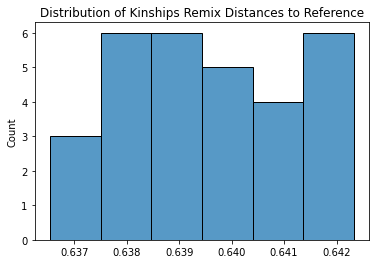

In [4]:
sns.histplot(remix_distances)
plt.title(f'Distribution of {reference_dataset.__class__.__name__} Remix Distances to Reference')
plt.show()

In [5]:
def _run(dataset):
    return pipeline(
        model='RotatE',
        dataset=dataset,
        random_seed=random.randint(1, 2**32),
        device='cpu',
        training_kwargs=dict(num_epochs=30, tqdm_kwargs=dict(leave=False)),
        evaluation_kwargs=dict(tqdm_kwargs=dict(leave=False)),
    )

In [6]:
reference_results = _run(reference_dataset)
reference_metric = reference_results.metric_results.get_metric(metric)
reference_metric

0.22346368715083798

In [7]:
remix_results = [
    _run(remix)
    for remix in tqdm(remixes, desc=f'Remixed {reference_dataset.__class__.__name__}')    
]

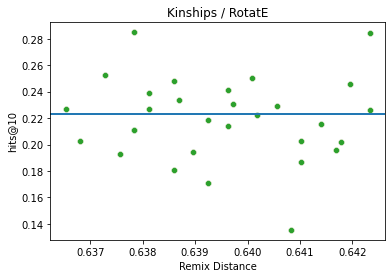

In [11]:
remix_metrics = [
    result.metric_results.get_metric(metric)
    for result in remix_results
]

plt.axhline(reference_metric)
sns.scatterplot(x=remix_distances, y=remix_metrics)
plt.xlabel('Remix Distance')
plt.ylabel(metric)
plt.title(f'{reference_dataset.__class__.__name__} / {reference_results.model.__class__.__name__}')
plt.show()

In [12]:
remixes = [
    remix_dataset(reference_dataset, random_state=random.randint(1, 2**32))
    for _ in range(trials)
]
remix_distances = [
    dataset_splits_distance(reference_dataset, remix)
    for remix in remixes
]

Report a one-sample T-test comparing the reference split to the others. A significant p-value means that remixes have different results. Here, it appears that remixes actually attain better results.

In [13]:
stats.ttest_1samp(remix_metrics, reference_metric)

Ttest_1sampResult(statistic=-0.7299777423682281, pvalue=0.47125974975241025)